# Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load data

In [2]:
DATASET_PATH = "./data"
BERKLEYEARTH_DATASETS = os.path.join(DATASET_PATH, "berkeleyearth")
OWID_DATASETS = os.path.join(DATASET_PATH, "owid")

MONTHLY_ANOMALIES_CSV_PATH = os.path.join(BERKLEYEARTH_DATASETS, "Raw_TAVG_complete.csv")
CO2_EMISSION_CSV_PATH = os.path.join(OWID_DATASETS, "owid-co2-data.csv")

In [3]:
import pandas as pd

temperature_anomalies = pd.read_csv(MONTHLY_ANOMALIES_CSV_PATH)
anual_anomalies = temperature_anomalies[temperature_anomalies['month'] == 6][['year', 'annual_anomaly', 'ten_year_anomaly']]
anual_anomalies

,year,annual_anomaly,ten_year_anomaly
5,1750,0.183,NaN
17,1751,1.075,NaN
29,1752,NaN,NaN
41,1753,0.104,NaN
53,1754,0.785,NaN
...,...,...,...
3209,2017,1.364,NaN
3221,2018,1.208,NaN
3233,2019,1.395,NaN
3245,2020,1.556,NaN


In [4]:
co2_emission = pd.read_csv(CO2_EMISSION_CSV_PATH)
co2_emission_annually = co2_emission[["year", "co2"]].fillna(0).groupby(['year']).sum().reset_index()
co2_emission_annually

,year,co2
0,1750,56.106
1,1751,56.106
2,1752,56.124
3,1753,56.124
4,1754,56.148
...,...,...
267,2017,234500.508
268,2018,238741.382
269,2019,239925.740
270,2020,228766.484


# Calculate cumulative sum for CO2 emission

In [5]:
co2_emission_annually['cum_co2'] = co2_emission_annually['co2'].cumsum()
co2_emission_annually

,year,co2,cum_co2
0,1750,56.106,5.610600e+01
1,1751,56.106,1.122120e+02
2,1752,56.124,1.683360e+02
3,1753,56.124,2.244600e+02
4,1754,56.148,2.806080e+02
...,...,...,...
267,2017,234500.508,1.096420e+07
268,2018,238741.382,1.120294e+07
269,2019,239925.740,1.144287e+07
270,2020,228766.484,1.167164e+07


### CO2 emission for future. Assumptions used for furhter calculation

Temperature prediction assumes  

What will be cumulative co2 if
- emission won't change
- emission drops by 2 %
- emission increases by 2% 

In [6]:
emission_years = 100
base = np.array([[240609.645, 1.191225e+07]])
zeros = np.zeros(shape=(emission_years - 1, 2), dtype=None)

future_co2_emission_const = np.concatenate((base, zeros), axis=0)
for x in range(1, emission_years):
    co2_annual, co2_cumulative = future_co2_emission_const[x - 1]
    future_co2_emission_const[x] = [co2_annual, co2_annual + co2_cumulative]


future_co2_emission_2percent_drop = np.concatenate((base, zeros), axis=0)
for x in range(1, emission_years):
    co2_annual, co2_cumulative = future_co2_emission_2percent_drop[x - 1]
    co2_annual = co2_annual * (1 - 0.02)
    future_co2_emission_2percent_drop[x] = [co2_annual, co2_annual + co2_cumulative]


future_co2_emission_2percent_up = np.concatenate((base, zeros), axis=0)
for x in range(1, emission_years):
    co2_annual, co2_cumulative = future_co2_emission_2percent_up[x - 1]
    co2_annual = co2_annual * (1 + 0.02)
    future_co2_emission_2percent_up[x] = [co2_annual, co2_annual + co2_cumulative]

future_co2_emission = np.concatenate((np.delete(future_co2_emission_const, 0, axis = 1), 
           np.delete(future_co2_emission_2percent_drop, 0, axis = 1),
           np.delete(future_co2_emission_2percent_up, 0, axis = 1)
), axis = 1)

In [7]:
future_co2_emission_yearly = pd.DataFrame(future_co2_emission, columns = ['const', 'down_2%', 'up_2%'])
future_co2_emission_yearly['year'] = future_co2_emission_yearly.index + 2021
future_co2_emission_yearly

,const,down_2%,up_2%,year
0,1.191225e+07,1.191225e+07,1.191225e+07,2021
1,1.215286e+07,1.214805e+07,1.215767e+07,2022
2,1.239347e+07,1.237913e+07,1.240800e+07,2023
3,1.263408e+07,1.260559e+07,1.266334e+07,2024
4,1.287469e+07,1.282752e+07,1.292378e+07,2025
...,...,...,...,...
95,3.477017e+07,2.197236e+07,8.016037e+07,2116
96,3.501078e+07,2.200696e+07,8.177076e+07,2117
97,3.525139e+07,2.204086e+07,8.341335e+07,2118
98,3.549200e+07,2.207408e+07,8.508879e+07,2119


# Join datasets

In [8]:
co2_emission_annually_since_1860 = co2_emission_annually[co2_emission_annually['year'] >= 1900]
annal_anomalies_since_1860 = anual_anomalies[anual_anomalies['year'] >= 1900]

anomalies_and_co2_anually = annal_anomalies_since_1860.merge(co2_emission_annually_since_1860, how = 'inner', left_on='year', right_on='year')
anomalies_and_co2_anually

,year,annual_anomaly,ten_year_anomaly,co2,cum_co2
0,1900,-0.032,-0.246,14890.575,3.418100e+05
1,1901,-0.023,-0.227,15262.882,3.570728e+05
2,1902,-0.236,-0.244,15559.653,3.726325e+05
3,1903,-0.313,-0.253,16827.715,3.894602e+05
4,1904,-0.474,-0.274,17052.632,4.065128e+05
...,...,...,...,...,...
117,2017,1.364,NaN,234500.508,1.096420e+07
118,2018,1.208,NaN,238741.382,1.120294e+07
119,2019,1.395,NaN,239925.740,1.144287e+07
120,2020,1.556,NaN,228766.484,1.167164e+07


array([[<AxesSubplot: xlabel='annual_anomaly', ylabel='annual_anomaly'>,
        <AxesSubplot: xlabel='co2', ylabel='annual_anomaly'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='annual_anomaly'>,
        <AxesSubplot: xlabel='cum_co2', ylabel='annual_anomaly'>],
       [<AxesSubplot: xlabel='annual_anomaly', ylabel='co2'>,
        <AxesSubplot: xlabel='co2', ylabel='co2'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='co2'>,
        <AxesSubplot: xlabel='cum_co2', ylabel='co2'>],
       [<AxesSubplot: xlabel='annual_anomaly', ylabel='ten_year_anomaly'>,
        <AxesSubplot: xlabel='co2', ylabel='ten_year_anomaly'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='ten_year_anomaly'>,
        <AxesSubplot: xlabel='cum_co2', ylabel='ten_year_anomaly'>],
       [<AxesSubplot: xlabel='annual_anomaly', ylabel='cum_co2'>,
        <AxesSubplot: xlabel='co2', ylabel='cum_co2'>,
        <AxesSubplot: xlabel='ten_year_anomaly', ylabel='cum_co2'>,
        <AxesSub

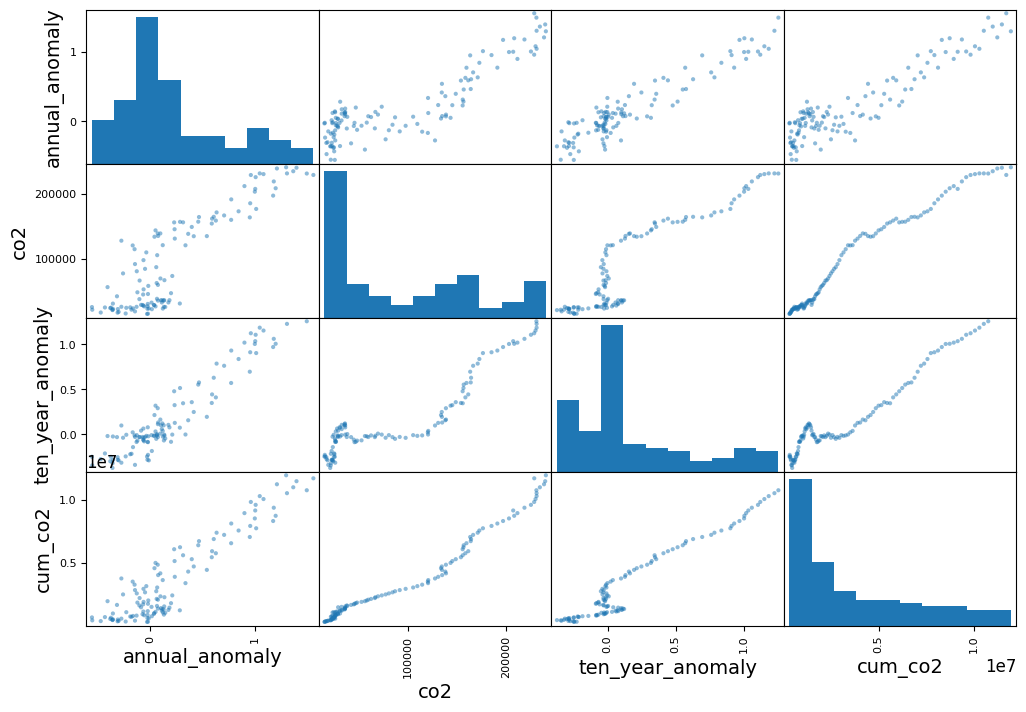

In [9]:
from pandas.plotting import scatter_matrix

attributes = ['annual_anomaly', "co2", 'ten_year_anomaly', 'cum_co2']
scatter_matrix(anomalies_and_co2_anually[attributes], figsize=(12,8))

In [10]:
anomalies_and_co2_anually.corr()

,year,annual_anomaly,ten_year_anomaly,co2,cum_co2
year,1.000000,0.841487,0.881124,0.957844,0.933063
annual_anomaly,0.841487,1.000000,0.938394,0.878617,0.926749
ten_year_anomaly,0.881124,0.938394,1.000000,0.916015,0.967357
co2,0.957844,0.878617,0.916015,1.000000,0.981532
cum_co2,0.933063,0.926749,0.967357,0.981532,1.000000


# Linear Regression

###  Normalize emission of co2 and anomalies

In [11]:
from sklearn import preprocessing as pre

co2 = anomalies_and_co2_anually[["co2"]]
co2_norm = pre.MinMaxScaler().fit_transform(co2)

cum_co2 = anomalies_and_co2_anually[["cum_co2"]]
cum_co2_norm = pre.MinMaxScaler().fit_transform(cum_co2)

annual_anomaly = anomalies_and_co2_anually[["annual_anomaly"]]
annual_anomaly_norm = pre.MinMaxScaler().fit_transform(annual_anomaly)

ten_year_anomaly = anomalies_and_co2_anually[["ten_year_anomaly"]]
ten_year_anomaly_norm = pre.MinMaxScaler().fit_transform(ten_year_anomaly)


In [12]:
to_normalized_value = anomalies_and_co2_anually[["co2", "cum_co2", "annual_anomaly", "ten_year_anomaly"]].values

min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(to_normalized_value)
df_scaled = pd.DataFrame(x_scaled, columns = ["co2", "cum_co2", "annual_anomaly", "ten_year_anomaly"], index = anomalies_and_co2_anually.index)

df_scaled['year'] = anomalies_and_co2_anually[["year"]]
anomalies_and_co2_anually_scaled = df_scaled


In [13]:
anomalies_and_co2_anually_scaled

,co2,cum_co2,annual_anomaly,ten_year_anomaly,year
0,0.000000,0.000000,0.248817,0.077396,1900
1,0.001649,0.001319,0.253075,0.089066,1901
2,0.002964,0.002664,0.152318,0.078624,1902
3,0.008582,0.004118,0.115894,0.073096,1903
4,0.009579,0.005592,0.039735,0.060197,1904
...,...,...,...,...,...
117,0.972935,0.918063,0.909177,NaN,2017
118,0.991723,0.938697,0.835383,NaN,2018
119,0.996970,0.959433,0.923841,NaN,2019
120,0.947531,0.979205,1.000000,NaN,2020


In [14]:
co2_max = 1.191225e+07
future_co2_emission_yearly[['const_norm']] = future_co2_emission_yearly[['const']] / co2_max
future_co2_emission_yearly[['down_2%_norm']] = future_co2_emission_yearly[['down_2%']] / co2_max
future_co2_emission_yearly[['up_2%_norm']] = future_co2_emission_yearly[['up_2%']] / co2_max
future_co2_emission = future_co2_emission_yearly.iloc[1:]
future_co2_emission

,const,down_2%,up_2%,year,const_norm,down_2%_norm,up_2%_norm
1,1.215286e+07,1.214805e+07,1.215767e+07,2022,1.020199,1.019795,1.020602
2,1.239347e+07,1.237913e+07,1.240800e+07,2023,1.040397,1.039193,1.041617
3,1.263408e+07,1.260559e+07,1.266334e+07,2024,1.060596,1.058204,1.063052
4,1.287469e+07,1.282752e+07,1.292378e+07,2025,1.080794,1.076834,1.084915
5,1.311530e+07,1.304501e+07,1.318944e+07,2026,1.100993,1.095092,1.107216
...,...,...,...,...,...,...,...
95,3.477017e+07,2.197236e+07,8.016037e+07,2116,2.918858,1.844518,6.729239
96,3.501078e+07,2.200696e+07,8.177076e+07,2117,2.939057,1.847422,6.864426
97,3.525139e+07,2.204086e+07,8.341335e+07,2118,2.959255,1.850268,7.002317
98,3.549200e+07,2.207408e+07,8.508879e+07,2119,2.979454,1.853058,7.142966


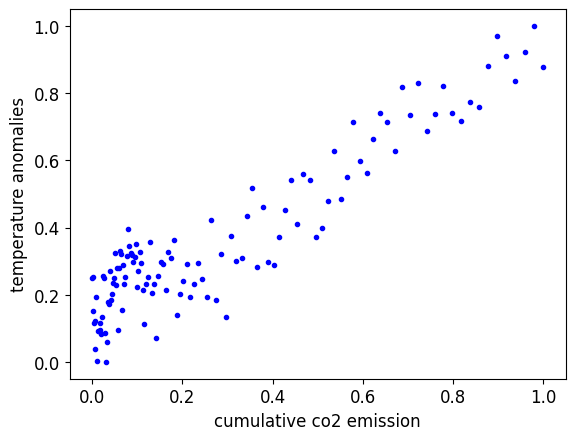

In [15]:
Y = anomalies_and_co2_anually_scaled[['annual_anomaly']]
X = anomalies_and_co2_anually_scaled[['cum_co2']]


plt.plot(X, Y, ".b")
plt.xlabel("cumulative co2 emission", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
plt.savefig('cumulative-co2-temperature.png')
plt.show()


### Normal eqation method
We'll use *normal equation* for calcuation linear regression parameters

$$
\Theta = (X^TX)^{-1}X^Ty
$$

In [16]:
import numpy as np

x_len, _ = X.shape
X_b = np.c_[np.ones((x_len, 1)), X]

# normal equation for linear regression 
theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)

In [17]:
theta

array([[0.14551849],
       [0.7704561 ]])

In [18]:
# we want to calculate y value for points x = 0 and x = 1
X_new = np.array([[0], [1]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
Y_predict = X_new_b.dot(theta)
Y_predict


array([[0.14551849],
       [0.9159746 ]])

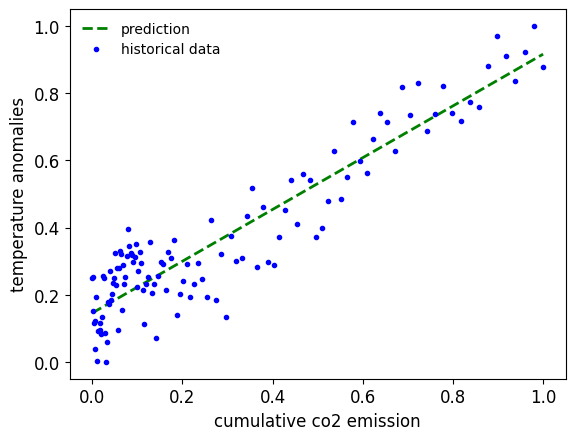

In [19]:
plt.plot(X_new, Y_predict, "g--", linewidth=2, label = "prediction")
plt.plot(X, Y, "b.", linewidth=2, label = "historical data")
plt.xlabel("cumulative co2 emission", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
legend=plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.savefig('linear-regression.png')
plt.show()

### Latest square method


In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, Y)
lin_reg.intercept_, lin_reg.coef_


(array([0.14551849]), array([[0.7704561]]))

In [21]:
# prediction for x=0 and x=1
lin_reg.predict(X_new)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([[0.14551849],
       [0.9159746 ]])

In [22]:
# Coefficient of determination of the prediction.
lin_reg.score(X,Y)

0.8588639205536893

# Method used for prediction

In [23]:
def predict_history(anomalies_and_co2_anually_scaled, model):
    columns = ['year', 'co2', 'annual_anomaly']
    anomalies_history_pred = anomalies_and_co2_anually_scaled[columns]
    X_cum_co2 = anomalies_history_pred['co2'].values.reshape(-1, 1)
    Y_anomalies_history_pred = model.predict(X_cum_co2)
    anomalies_history_pred.insert(len(columns), 'annual_anomaly_pred', Y_anomalies_history_pred)
    return anomalies_history_pred

def predict_future(future_co2_emission, model):
    columns = ['year', 'co2']
    anomalies_prediction = future_co2_emission[columns]
    X_const_norm = anomalies_prediction['co2'].values.reshape(-1, 1)
    Y_anual_anomaly_pred = model.predict(X_const_norm)
    anomalies_prediction.insert(len(columns), 'annual_anomaly_pred', Y_anual_anomaly_pred)
    return anomalies_prediction

def create_datasets(anomalies_and_co2_anually_scaled, future_co2_emission, model):
    anomalies_hist = anomalies_and_co2_anually_scaled[['year', 'cum_co2', 'annual_anomaly']].rename(columns={'cum_co2': 'co2'})
    anomalies_future = future_co2_emission.rename(columns={'const_norm': 'co2'})
    anomalies_future_down = future_co2_emission.rename(columns={'down_2%_norm': 'co2'})
    anomalies_future_up = future_co2_emission.rename(columns={'up_2%_norm': 'co2'})
    hist = predict_history(anomalies_hist, model)
    future = predict_future(anomalies_future, model)
    future_down = predict_future(anomalies_future_down, model)
    future_up = predict_future(anomalies_future_up, model)
    future_up = future_up[future_up['year'] < 2076]
    history = pd.concat([hist, future])
    return history, future_down, future_up 

# Polynomial Regression

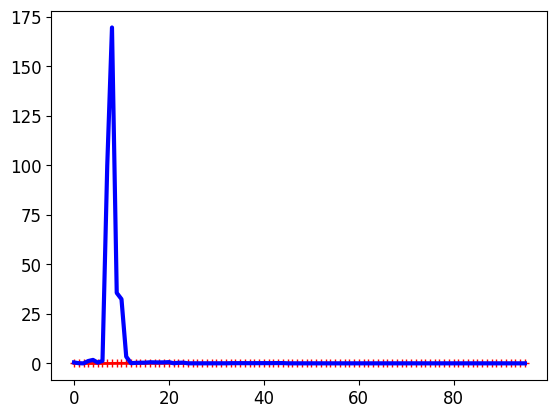

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curvers(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        # train
        model.fit(X_train[:m], y_train[:m])
        # predict
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val[:m])
        # calculate errors
        train_err = mean_squared_error(y_train[:m], y_train_predict)
        val_err = mean_squared_error(y_val[:m], y_val_predict)
        # append errors
        train_errors.append(train_err)
        val_errors.append(val_err)
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

polynomial_regression = Pipeline([
     ("poly_features", PolynomialFeatures(degree=6, include_bias=False)),
     ("lin_reg", LinearRegression()),
   ])

plot_learning_curvers(polynomial_regression, X, Y)


## Choosing parameters

Let's decide that polynomial degree `m = 2` and `test_size = 0.2`

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


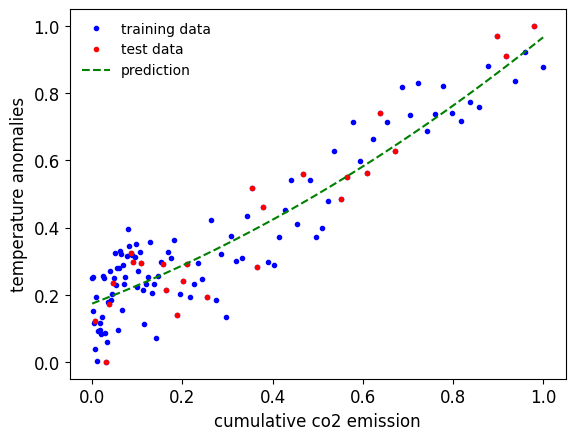

In [25]:
model = Pipeline([
     ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
     ("lin_reg", LinearRegression()),
   ])

X_new = np.linspace(0, 1, 100).reshape(100, 1)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

model.fit(X_train, Y_train)
# X_val = np.sort(X_val, axis = 0)
Y_val_predict = model.predict(X_val)
Y_new = model.predict(X_new)

plt.plot(X, Y, "b.", label = "training data")
plt.plot(X_val, Y_val, "r.", label = "test data")
plt.plot(X_new,Y_new, "g--", label = "prediction")
plt.xlabel("cumulative co2 emission", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
legend=plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.savefig('polynomial-regression.png')
plt.show()

### Model accuracy

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(mean_squared_error(Y_val ,Y_val_predict))
model.score(X,Y)

0.0071909974433517435


0.8671941515825254

### Prediction

In [27]:
anomalies_hist = anomalies_and_co2_anually_scaled[['year', 'cum_co2', 'annual_anomaly']].rename(columns={'cum_co2': 'co2'})
anomalies_future = future_co2_emission.rename(columns={'const_norm': 'co2'})
anomalies_future_down = future_co2_emission.rename(columns={'down_2%_norm': 'co2'})
anomalies_future_up = future_co2_emission.rename(columns={'up_2%_norm': 'co2'})
hist = predict_history(anomalies_hist, model)
future = predict_future(anomalies_future, model)
future_down = predict_future(anomalies_future_down, model)
future_up = predict_future(anomalies_future_up, model)
future_up_ = future_up
future_up = future_up[future_up['year'] < 2076]
summary = pd.concat([hist, future])

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


Concatenation of history and prediction

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


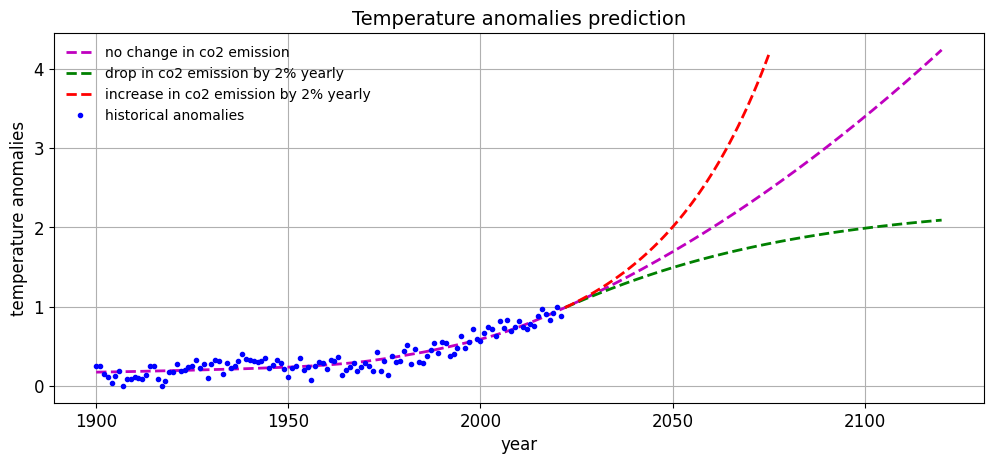

In [28]:
summary, future_down, future_up = create_datasets(anomalies_and_co2_anually_scaled, future_co2_emission, model)

plt.figure().set_figwidth(12)
plt.plot(summary[['year']], summary[['annual_anomaly_pred']], "m--", linewidth=2, label="no change in co2 emission")
plt.plot(future_down[['year']], future_down[['annual_anomaly_pred']], "g--", linewidth=2, label="drop in co2 emission by 2% yearly")
plt.plot(future_up[['year']], future_up[['annual_anomaly_pred']], "r--", linewidth=2, label="increase in co2 emission by 2% yearly")
plt.plot(summary[['year']], summary[['annual_anomaly']], "b.", linewidth=1, label="historical anomalies")

plt.xlabel("year", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
legend=plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.grid()
plt.title('Temperature anomalies prediction', fontsize = 14)
plt.savefig('polynomial-regression-result.png')
plt.show()

## Scenario 1. CO2 emission remains the same as in 2021

In [29]:
future_years = future[(future['year'] == 2050) | (future['year'] == 2075) | (future['year'] == 2100)]
future_years['temperature in C'] = future_years['annual_anomaly_pred'] * 1.3
future_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/3038734967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_years['temperature in C'] = future_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.585757,1.691267,2.198647
54,2075,2.090719,2.471217,3.212582
79,2100,2.595682,3.394489,4.412836


## Scenario 2. CO2 emission drops yearly by 2%

In [30]:
future_down_years = future_down[(future_down['year'] == 2050) | (future_down['year'] == 2075) | (future_down['year'] == 2100)]
future_down_years['temperature in C'] = future_down_years['annual_anomaly_pred'] * 1.3
future_down_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/4227426479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_down_years['temperature in C'] = future_down_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.438828,1.491244,1.938617
54,2075,1.657279,1.793026,2.330933
79,2100,1.789106,1.988118,2.584553


## Scenario 3. CO2 emission increases yearly by 2%

In [31]:
future_up_years = future_up_[(future_up_['year'] == 2050) | (future_up_['year'] == 2075) | (future_up_['year'] == 2100)]
future_up_years['temperature in C'] = future_up_years['annual_anomaly_pred'] * 1.3
future_up_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/3963687825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_up_years['temperature in C'] = future_up_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.799216,2.003482,2.604527
54,2075,2.971102,4.173794,5.425932
79,2100,4.893705,9.406446,12.228380


# Ridge Regression

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


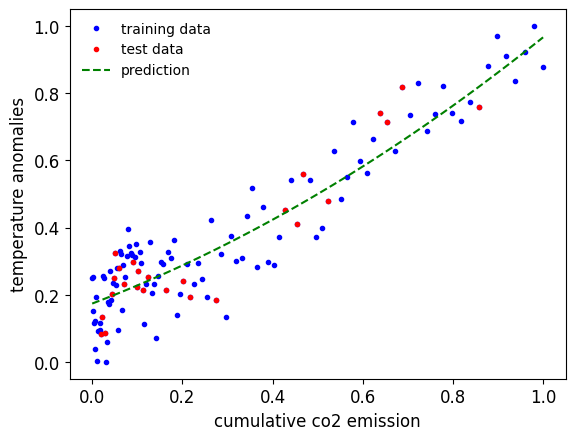

In [32]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

X_new = np.linspace(0, 1, 100).reshape(100, 1)
y = Y

alpha = 10**-5

style = "--g"
model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", Ridge(alpha, random_state=42)),
    ])
model.fit(X_train, Y_train)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
# plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

plt.plot(X, Y, "b.", label = "training data")
plt.plot(X_val, Y_val, "r.", label = "test data")
plt.plot(X_new,Y_new, "g--", label = "prediction")
plt.xlabel("cumulative co2 emission", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
legend=plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.savefig('ridge-regression.png')
plt.show()


### Model accuracy

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print(mean_squared_error(Y_val ,Y_val_predict))
model.score(X,Y)

0.06953607728740523


0.867719166571156

### Prediction

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


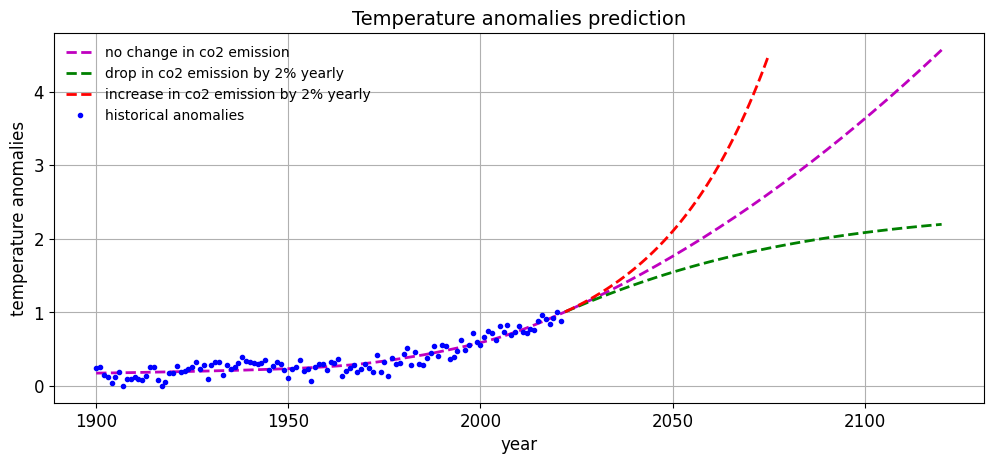

In [34]:
anomalies_hist = anomalies_and_co2_anually_scaled[['year', 'cum_co2', 'annual_anomaly']].rename(columns={'cum_co2': 'co2'})
anomalies_future = future_co2_emission.rename(columns={'const_norm': 'co2'})
anomalies_future_down = future_co2_emission.rename(columns={'down_2%_norm': 'co2'})
anomalies_future_up = future_co2_emission.rename(columns={'up_2%_norm': 'co2'})
hist = predict_history(anomalies_hist, model)
future = predict_future(anomalies_future, model)
future_down = predict_future(anomalies_future_down, model)
future_up = predict_future(anomalies_future_up, model)
future_up = future_up[future_up['year'] < 2076]
summary = pd.concat([hist, future])

plt.figure().set_figwidth(12)
plt.plot(summary[['year']], summary[['annual_anomaly_pred']], "m--", linewidth=2, label="no change in co2 emission")
plt.plot(future_down[['year']], future_down[['annual_anomaly_pred']], "g--", linewidth=2, label="drop in co2 emission by 2% yearly")
plt.plot(future_up[['year']], future_up[['annual_anomaly_pred']], "r--", linewidth=2, label="increase in co2 emission by 2% yearly")
plt.plot(summary[['year']], summary[['annual_anomaly']], "b.", linewidth=1, label="historical anomalies")

plt.xlabel("year", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
legend=plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.grid()
plt.title('Temperature anomalies prediction', fontsize = 14)
plt.savefig('ridge-regression-result.png')
plt.show()

## Scenario 1. CO2 emission remains the same as in 2021

In [35]:
future_years = future[(future['year'] == 2050) | (future['year'] == 2075) | (future['year'] == 2100)]
future_years['temperature in C'] = future_years['annual_anomaly_pred'] * 1.3
future_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/3038734967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_years['temperature in C'] = future_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.585757,1.762018,2.290623
54,2075,2.090719,2.613690,3.397797
79,2100,2.595682,3.632494,4.722242


## Scenario 2. CO2 emission drops yearly by 2%

In [36]:
future_down_years = future_down[(future_down['year'] == 2050) | (future_down['year'] == 2075) | (future_down['year'] == 2100)]
future_down_years['temperature in C'] = future_down_years['annual_anomaly_pred'] * 1.3
future_down_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/4227426479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_down_years['temperature in C'] = future_down_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.438828,1.545598,2.009277
54,2075,1.657279,1.872488,2.434234
79,2100,1.789106,2.084888,2.710354


## Scenario 3. CO2 emission increases yearly by 2%

In [37]:
future_up_years = future_up_[(future_up_['year'] == 2050) | (future_up_['year'] == 2075) | (future_up_['year'] == 2100)]
future_up_years['temperature in C'] = future_up_years['annual_anomaly_pred'] * 1.3
future_up_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/3963687825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_up_years['temperature in C'] = future_up_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.799216,2.003482,2.604527
54,2075,2.971102,4.173794,5.425932
79,2100,4.893705,9.406446,12.228380


# Lasso Regression

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


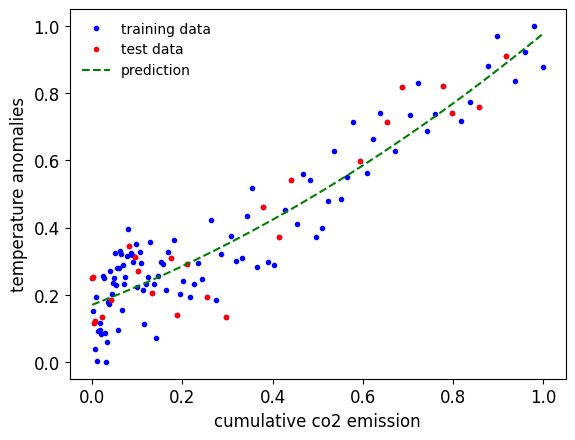

In [38]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)
X_new = np.linspace(0, 1, 100).reshape(100, 1)
y = Y

alpha = 10**-7

style = "--g"
model = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("std_scaler", StandardScaler()),
        ("regul_reg", Lasso(alpha, random_state=42)),
    ])
model.fit(X_train, Y_train)
y_new_regul = model.predict(X_new)
lw = 2 if alpha > 0 else 1
# plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))

# plt.plot(X, y, "b.", linewidth=3)
# plt.legend(loc="upper left", fontsize=15)
# plt.xlabel("cumulative co2 emission", fontsize=12)
# plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
# # plt.savefig('lasso-regression.png')
# plt.show()


plt.plot(X, y, "b.", label = "training data")
plt.plot(X_val, Y_val, "r.", label = "test data")
plt.plot(X_new, y_new_regul, "g--", label = "prediction")
plt.xlabel("cumulative co2 emission", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
legend=plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.savefig('lasso-regression.png')
plt.show()

In [39]:
Y_val_predict = model.predict(X_val)

mean_squared_error(Y_val ,Y_val_predict)
model.score(X,Y)

0.8677390075091799

/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


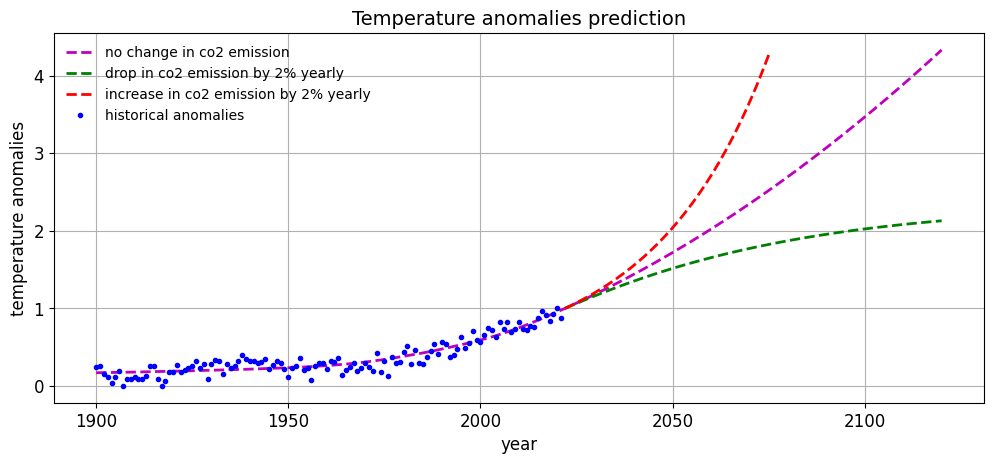

,year,co2,annual_anomaly,annual_anomaly_pred
0,1900,0.000000,0.248817,0.170120
1,1901,0.001319,0.253075,0.170802
2,1902,0.002664,0.152318,0.171499
3,1903,0.004118,0.115894,0.172253
4,1904,0.005592,0.039735,0.173019
...,...,...,...,...
95,2116,2.918858,NaN,4.149466
96,2117,2.939057,NaN,4.194219
97,2118,2.959255,NaN,4.239208
98,2119,2.979454,NaN,4.284434


In [40]:
anomalies_hist = anomalies_and_co2_anually_scaled[['year', 'cum_co2', 'annual_anomaly']].rename(columns={'cum_co2': 'co2'})
anomalies_future = future_co2_emission.rename(columns={'const_norm': 'co2'})
anomalies_future_down = future_co2_emission.rename(columns={'down_2%_norm': 'co2'})
anomalies_future_up = future_co2_emission.rename(columns={'up_2%_norm': 'co2'})
hist = predict_history(anomalies_hist, model)
future = predict_future(anomalies_future, model)
future_down = predict_future(anomalies_future_down, model)
future_up = predict_future(anomalies_future_up, model)
future_up_ = future_up
future_up = future_up[future_up['year'] < 2076]
summary = pd.concat([hist, future])

plt.figure().set_figwidth(12)
plt.plot(summary[['year']], summary[['annual_anomaly_pred']], "m--", linewidth=2, label="no change in co2 emission")
plt.plot(future_down[['year']], future_down[['annual_anomaly_pred']], "g--", linewidth=2, label="drop in co2 emission by 2% yearly")
plt.plot(future_up[['year']], future_up[['annual_anomaly_pred']], "r--", linewidth=2, label="increase in co2 emission by 2% yearly")
plt.plot(summary[['year']], summary[['annual_anomaly']], "b.", linewidth=1, label="historical anomalies")

plt.xlabel("year", fontsize=12)
plt.ylabel("temperature anomalies", rotation=90, fontsize=12)
legend=plt.legend(loc="upper left", fontsize=10, frameon=False)
plt.grid()
plt.title('Temperature anomalies prediction', fontsize = 14)
plt.savefig('lasso-regression-result.png')
plt.show()
summary

In [41]:
future_years = future[(future['year'] == 2050) | (future['year'] == 2075) | (future['year'] == 2100)]
future_years['temperature in C'] = future_years['annual_anomaly_pred'] * 1.3
future_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/3038734967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_years['temperature in C'] = future_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.585757,1.718968,2.234658
54,2075,2.090719,2.518340,3.273842
79,2100,2.595682,3.465604,4.505285


In [42]:
future_down_years = future_down[(future_down['year'] == 2050) | (future_down['year'] == 2075) | (future_down['year'] == 2100)]
future_down_years['temperature in C'] = future_down_years['annual_anomaly_pred'] * 1.3
future_down_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/4227426479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_down_years['temperature in C'] = future_down_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.438828,1.514152,1.968398
54,2075,1.657279,1.823200,2.370160
79,2100,1.789106,2.023090,2.630018


In [43]:
future_up_years = future_up_[(future_up_['year'] == 2050) | (future_up_['year'] == 2075) | (future_up_['year'] == 2100)]
future_up_years['temperature in C'] = future_up_years['annual_anomaly_pred'] * 1.3
future_up_years

/var/folders/p3/7xlmsjkd7hggrkvvtvd9dwy80000gn/T/ipykernel_9463/3963687825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_up_years['temperature in C'] = future_up_years['annual_anomaly_pred'] * 1.3


,year,co2,annual_anomaly_pred,temperature in C
29,2050,1.799216,2.038836,2.650487
54,2075,2.971102,4.265706,5.545418
79,2100,4.893705,9.644464,12.537803
